<a href="https://colab.research.google.com/github/BRomans/IdMind/blob/main/eeg_biometrics_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load libraries & initialise environment

In [2]:
# import libraries
from google.colab import drive
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from copy import deepcopy
from sklearn.externals import joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
import tensorflow as tf

from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, Reshape, \
          RepeatVector, MaxPooling1D, Conv1D, Flatten, Conv1DTranspose, UpSampling1D
from keras.models import Model, Sequential
from keras import regularizers

from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [3]:
drive.mount("/content/drive")
dirpath = "/content/drive/MyDrive/ml2-eeg-biometrics/train-test-data/" 

Mounted at /content/drive


In [4]:
# set random seed
seed(10)
tf.compat.v1.set_random_seed(10)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## Load & Process Data




##### Load data

To begin with, we load the 3 parts of the dataset, training, test and validation that we split in the pre-processing phase.

In [5]:
def load_datasets():
  x_train = np.asarray(np.load(dirpath + 'x_train.npy')).astype(np.float32)
  x_test = np.asarray(np.load(dirpath + 'x_test.npy', allow_pickle=True)).astype(np.float32)
  x_valid = np.asarray(np.load(dirpath + 'x_valid.npy', allow_pickle=True)).astype(np.float32)
  return x_train, x_test, x_valid

In [6]:
x_train_unscaled, x_test_unscaled, x_valid_unscaled  = load_datasets()
print("Data loaded. Shapes:")
print(x_train_unscaled.shape, x_test_unscaled.shape, x_valid_unscaled.shape)

Data loaded. Shapes:
(6665, 2500, 9) (419, 2500, 9) (1300, 2500, 9)


##### Plot distributions of unscaled data

In [7]:
cols = ['Statistic','F3', 'F4', 'FC3', 'FC4', 'C3', 'Cz', 'C4', 'CP3', 'CP4']
def data_summary(dataset, label):
  """ 
  input:
    dataset     the three dimensional input (n_samples, n_timepoints, n_features) 

    Prints histograms for the 9 features individually
  returns: 
    summ_df     pd.DataFrame containing summary statistics for the 9 features.
  """
  data = dataset.reshape((dataset.shape[0] * dataset.shape[1], dataset.shape[2])) # Reshape to 2D (n_samples*n_timepoints, n_features)
  
  # Calculate the summary statistics.
  min   = data.min(axis=0).reshape(1, data.shape[1])                  # Calculate the minimum over the rows for each column.
  max   = data.max(axis=0).reshape(1, data.shape[1])                  # Then reshape the result to one row and n_cols=n_features, to make it easier to combine later.
  mean  = data.mean(axis=0).reshape(1, data.shape[1])
  var   = data.var(axis=0).reshape(1, data.shape[1])
  q01   = np.quantile(data, 0.01, axis=0).reshape(1, data.shape[1])
  q99   = np.quantile(data, 0.99, axis=0).reshape(1, data.shape[1])

  names=np.array([['min','max','mean','var','1st percentile', '99th percentile']]).reshape(6,1) # Create a column of names for the summary stats.
  stats = np.concatenate((min,max,mean,var,q01,q99), axis=0)          # Combine the summary stats in one array

  summ = np.concatenate((names, np.round(stats, 4)), axis=1)          # Combine the summary stats with their names.
  summ_df = pd.DataFrame(summ, columns=cols)                          # Create a dataframe and supply the channel names as columns.

  # Plot histograms per channel.
  fig, axes = plt.subplots(3,3, figsize = (9,9))
  axes=axes.ravel()
  for i in range(9): # Loop through the channels.
    axes[i].hist(data[:,i], range= (q01[0,i], q99[0,i]),   density=True)    # Add histogram subplot for the values of that channel.
    axes[i].title.set_text(cols[i+1])                                       # Add a title with the channel name.
  fig.suptitle("Distribution for each channel (between 1st & 99th percentile) of " + label + " dataset" , size=16)
  fig.tight_layout(rect=[0, 0.03, 1, 0.95])                                 # Cut the plot space to make space for the global title.

  return summ_df

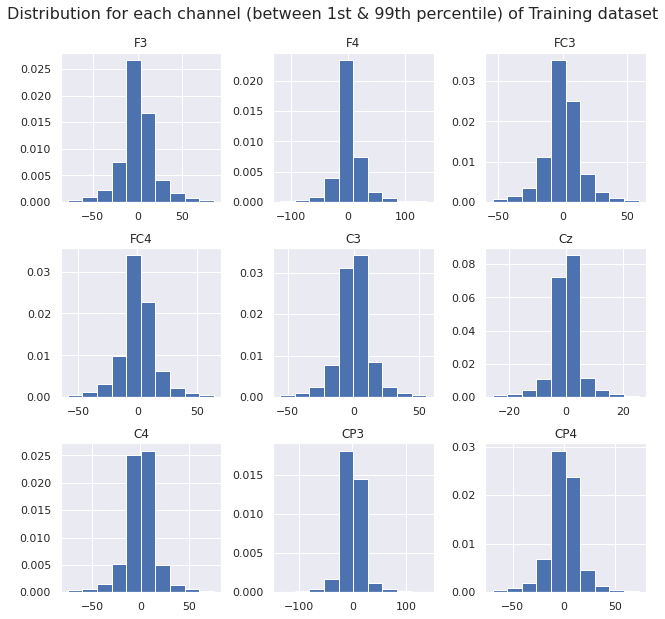

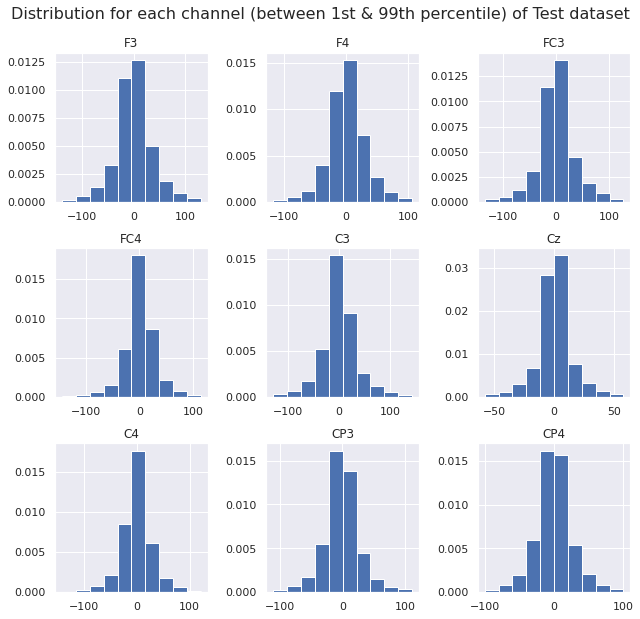

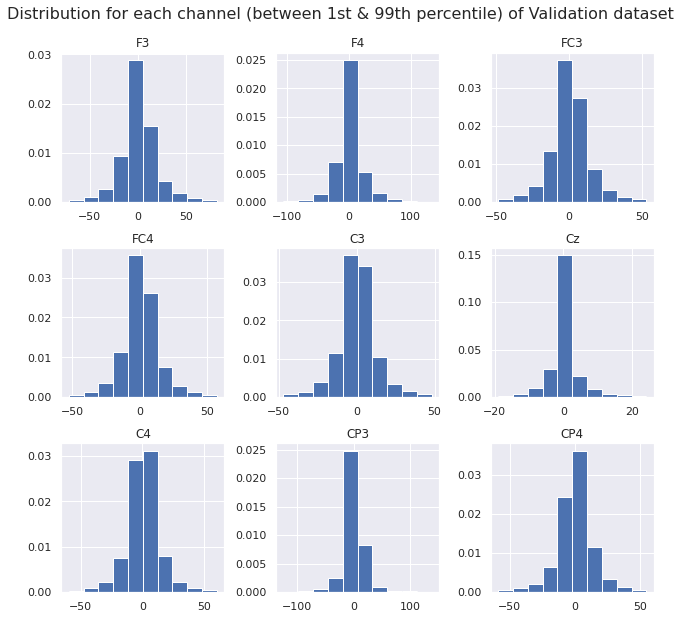

In [8]:
# Plot distributions of each channel.
unscaled_training_summary = data_summary(x_train_unscaled, "Training")
unscaled_test_summary = data_summary(x_test_unscaled, "Test")
unscaled_valid_summary = data_summary(x_valid_unscaled, "Validation")


### Band-pass filter

##### Create the filters and apply across the whole data

In [10]:
from scipy import signal
from copy import deepcopy

low_cut = 0.5
high_cut = 33.0

bp = signal.butter(10, (low_cut,high_cut), 'bp', fs=500, output='sos') # Create the filter. fs is the sampling rate.

# Create copies of the data
x_train_filtered = deepcopy(x_train_unscaled)         # After running once in the session, I comment these out because otherwise if you re-run the cell it eats RAM.
x_test_filtered = deepcopy(x_test_unscaled)
x_valid_filtered = deepcopy(x_valid_unscaled)

print(x_train_filtered.shape)

x_train_filtered = signal.sosfilt(bp, x_train_filtered, axis=1)

(6665, 2500, 9)


##### Plot distributions of the total dataset after the band-pass filter

In [ ]:
data_summary(x_train_filtered)

### Smooth out extreme points beyond the 1st-99th percentile

In [11]:
# Reshape to 2 dimensional array
x_train = deepcopy(x_train_unscaled)
x_test = deepcopy(x_test_unscaled)
x_valid = deepcopy(x_valid_unscaled)

n_samples, n_timepoints, n_features = x_train.shape
n_samples_test =  x_test.shape[0]
n_samples_valid = x_valid.shape[0]

x_train = x_train.reshape((n_samples*n_timepoints, n_features))
x_test = x_test.reshape((n_samples_test*n_timepoints, n_features))
x_valid = x_valid.reshape((n_samples_valid*n_timepoints, n_features))


# Find the 1st & 99th percentiles for each column of the training data.
q01  = np.quantile(x_train, 0.01, axis=0)
q99  = np.quantile(x_train, 0.99, axis=0)

# Loop through the columns and apply the cutoff
for i in range(x_train.shape[1]):
  x_train[x_train[:,i] < q01[i], i] = q01[i] # If the value is below the 1st percentile, replace with the 1st percentile.
  x_train[x_train[:,i] > q99[i], i] = q99[i] # If the value is above the 99th percentile, replace with the 99th percentile.
  # Do the same with the test and validation data, using the cutoffs calculated from the training data.
  x_test[x_test[:,i] < q01[i], i] = q01[i] 
  x_test[x_test[:,i] > q99[i], i] = q99[i] 
  x_valid[x_valid[:,i] < q01[i], i] = q01[i] 
  x_valid[x_valid[:,i] > q99[i], i] = q99[i] 

### Scale the data

##### Scale the artificially smoothed data.

In [12]:
# normalize the data
scaler = MinMaxScaler()

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_valid = scaler.transform(x_valid)
scaler_filename = "/content/drive/MyDrive/ml2-eeg-biometrics/scaler_data"
joblib.dump(scaler, scaler_filename)

# Reshape to 3D for the convolutional autoencoder
x_train = x_train.reshape((n_samples, n_timepoints, n_features))
x_test = x_test.reshape((n_samples_test, n_timepoints, n_features))
x_valid = x_valid.reshape((n_samples_valid, n_timepoints, n_features))
print("x_train shape: ", x_train.shape, "x_test shape:", x_test.shape, "x_valid shape:", x_valid.shape)

x_train shape:  (6665, 2500, 9) x_test shape: (419, 2500, 9) x_valid shape: (1300, 2500, 9)


##### Scale the filtered data.

In [ ]:
# Scaling applied to the filtered signal.
scaler_filtered = MinMaxScaler()

n_samples, n_timepoints, n_features = x_train_filtered.shape
n_samples_test =  x_test_filtered.shape[0]

# Reshape to 2D for the scaler.
x_train_filtered = x_train_filtered.reshape((n_samples*n_timepoints, n_features))
# x_test_filtered = x_test_filtered.reshape((n_samples_test*n_timepoints, n_features))

# Apply the scaling.
x_train_filtered = scaler_filtered.fit_transform(x_train_filtered)
# x_test_filtered = scaler_filtered.transform(x_test_filtered)

# Re-shape back to 3D for the convolutional autoencoder.
x_train_filtered = x_train_filtered.reshape((n_samples, n_timepoints, n_features))    
# x_test_filtered = x_test_filtered.reshape((n_samples_test, n_timepoints, n_features))


In [ ]:
# data_summary(x_train)     # Plot the distribution of the scaled data.

##### Visualise the Raw & Scaled Signals

In [ ]:
labels=[(('F3',0), ('F4',1)), (('FC3',2), ('FC4',3)), (('C3',4), ('Cz',5), ('C4',6)), (('CP3',7), ('CP4',8))]
colours= ['darkslateblue', 'orange','lightskyblue','brown','darkgreen','darkgrey','bisque','violet','palegreen']

def plot_signals(sample, title=None):
  fig, axes = plt.subplots(2,2, figsize = (6,6))
  axes=axes.ravel()
  plt.suptitle("Signals" if title is None else title, size=16)
  count=0
  for label_group in labels:
    for label, ind in label_group:
      axes[count].plot(sample[:,ind], label=label,color=colours[ind], alpha=0.8)
      axes[count].legend()
    count+=1

# plot_signals(x_train[101], title="Scaled Signals - x_train[0]")
# plot_signals(x_train_unscaled[101], title="Unscaled Signals - x_train[0]")

## Autoencoders

#### Convolutional Autoencoder

##### Define a convolutional autoencoder.

In [ ]:
# Testing around with adding or removing certain layers, no huge difference in performance vs. just using a simpler architecture outlined a few cells down.
def conv_autoencoder_model(X):
    inputs = Input(shape=(X.shape[1],X.shape[2]))
    e1 = Conv1D(18, 9, activation='relu', padding='same')(inputs)
    e2 = MaxPooling1D(2)(e1)
    e3 = Conv1D(6,5, activation = 'relu', padding='same')(e2)
    e4 = MaxPooling1D(5)(e3)
    e5 = Conv1D(2,3, activation = 'relu', padding='same')(e4)
    e6 = MaxPooling1D(2)(e5)
    encoded = Flatten()(e6)
    # encoded = Dense(100, activation='relu')(e5)
    # d1 = Dense(100, activation='relu')(encoded)
    d0 = Reshape((125,2))(encoded)
    d1 = UpSampling1D(2)(d0)
    d2 = Conv1DTranspose(6, 5, activation='relu', padding='same')(d1)    
    d3 = UpSampling1D(5)(d2)
    d4 = Conv1DTranspose(18, 5, activation='relu', padding='same')(d3)
    d5 = UpSampling1D(2)(d4)
    d6 = Conv1DTranspose(9, 9, activation='relu', padding='same')(d5)
    # decoded = Dense(500, activation='sigmoid')(d6)

    model = Model(inputs=inputs, outputs=d6)
    return model

In [ ]:
# create the autoencoder model
# model = conv_autoencoder_model(x_train_1f)
model = conv_autoencoder_model(x_train[:,:,:])
model.compile(optimizer='adam', loss='mae')
model.summary()

In [14]:
# https://stackoverflow.com/questions/49290895/how-to-implement-a-1d-convolutional-auto-encoder-in-keras-for-vector-data

class ConvAutoencoder():
  def __init__(self, loss, optimizer, shape):
      self.input_shape = shape       
      self.autoencoder_model = self.build_model()
      self.autoencoder_model.compile(loss=loss, optimizer=optimizer)
      self.autoencoder_model.summary()
  
  def build_model(self):
      input_layer = Input(shape=self.input_shape)
      
      # encoder
      x = Conv1D(filters=8, kernel_size=3, activation='relu', padding='same',dilation_rate=2)(input_layer) # When using this layer as the first layer in a model, provide an input_shape argument 
                                                                                                            # (tuple of integers or None, e.g. (10, 128) for sequences of 10 vectors of 128-dimensional vectors, 
                                                                                                            # or (None, 128) for variable-length sequences of 128-dimensional vectors.
      x1 = MaxPooling1D(pool_size=2)(x) # Downsamples the input representation by taking the maximum value over the window defined by pool_size. The window is shifted by strides. 
                                        # The resulting output when using "valid" padding option has a shape of: output_shape = (input_shape - pool_size + 1) / strides)
      x2 = Conv1D(filters=4,kernel_size=3, activation='relu', padding='same',dilation_rate=2)(x1)
      x3 = MaxPooling1D(pool_size=2)(x2)
      #x4 = AveragePooling1D()(x3)
      flat = Flatten()(x3)
      encoded = Dense(units=75)(flat)

      # decoder
      d1 = Dense(units=150)(encoded) # Densely-connected NN layer.
      d2 = Reshape((50,3))(d1) #Layer that reshapes inputs into the given shape.
      d3 = Conv1D(filters=4,kernel_size=1,strides=1, activation='relu', padding='same')(d2)
      d4 = UpSampling1D(size=5)(d3) #Repeats each temporal step size times along the time axis.
      d5 = Conv1D(filters=8,kernel_size=1,strides=1, activation='relu', padding='same')(d4)
      d6 = UpSampling1D(size=2)(d5)
      #d7 = UpSampling1D(size=2)(d6)
      decoded = Conv1D(filters=1,kernel_size=1,strides=1, activation='sigmoid', padding='same')(d6)

      model = Model(input_layer, decoded)
      model.output_shape
      return model
                    
  def train_model(self, x_train, x_val, epochs, batch_size=20):
      early_stopping = EarlyStopping(monitor='val_loss',
                                      min_delta=0,
                                      patience=5,
                                      verbose=1, 
                                      mode='auto')
      history = self.autoencoder_model.fit(x_train, x_train,
                                            batch_size=batch_size,
                                            epochs=epochs,
                                            validation_data=(x_val, x_val),
                                            callbacks=[early_stopping])
      plot_history(history)

  def train_subset(self, x_train, epochs, batch_size=20):
      history = self.autoencoder_model.fit(x_train[:,:,0], x_train[:,:,0], epochs=epochs,
                  batch_size=batch_size,
                  # validation_split=0.05
                  )
  def plot_history(history):
      plt.plot(history.history['loss'])
      plt.plot(history.history['val_loss'])
      plt.title('Model loss')
      plt.ylabel('Loss')
      plt.xlabel('Epoch')
      plt.legend(['Train', 'Test'], loc='upper left')
      plt.show()
      
  def eval_model(self, x_test):
      preds = self.autoencoder_model.predict(x_test)
      return preds

##### Fit the model.

In [ ]:
# fit the model to the data
nb_epochs = 20
batch_size = 20

x_1 = x_train[:,:,:]#.reshape((-1,2500,4))

history = model.fit(x_1, x_1, epochs=nb_epochs,
                    batch_size=batch_size,
                    validation_split=0.05
                    ).history

In [ ]:
# Obtain the encoder part of the model.
encoder = Model(model.input, model.layers[7].output)

encoder.summary()

##### Plot the reconstruction for individual samples.
Temporary code for assessing the models on the subset of data (one channel and only 20% of timepoints).

In [ ]:
x_pred = model.predict(x_1)

for i in range(0,len(x_1),200):
  plt.plot(x_1[i,:,0], label='actual')
  plt.plot(x_pred[i,:,0], label = 'predicted')
  plt.show()

In [ ]:
# Plot samples.
# x_pred = model.predict(x_train_filtered[:,:,0])
x_pred = model.predict(x_1)

# Plot actuals vs. prediction for one column across all rows
# plt.figure(figsize=(14,8))
# plt.scatter(x_train_filtered[:,0,3], x_pred[:,0,0],alpha=0.2)
# plt.show()

# # Plot actuals vs. predictions for one row across all columns
# plt.figure(figsize=(14,8))
# plt.plot(x_train_filtered[0,:,3], label='actual', alpha=0.7)
# plt.plot(x_pred[0,:,0], label= 'predicted',alpha=0.7)
# plt.legend()

# # Plot same as above for a different row
# plt.figure(figsize=(14,8))
# plt.plot(x_train_filtered[1039,:,3], label='actual', alpha=0.7)
# plt.plot(x_pred[1039,:,0], label= 'predicted',alpha=0.7)
# plt.legend()

plt.figure(figsize=(14,8))
plt.plot(x_1[1039,:,0], label='actual', alpha=0.7)
plt.plot(x_pred[1039,:,0], label= 'predicted',alpha=0.7)
# plt.ylim(0.475, 0.495)
plt.legend()


## Evaluate Results

In [ ]:
# Get the predicted values for the training set.
X_pred_3D = model.predict(x_train)
X_pred = X_pred_3D.reshape(X_pred_3D.shape[0]*X_pred_3D.shape[1], X_pred_3D.shape[2])
# X_pred = pd.DataFrame(X_pred, columns=train.columns)

##### Plot distribution of the loss

In [ ]:
# Plot the distribution of the loss
x_train_reshaped = x_train.reshape(x_train.shape[0]*x_train.shape[1], x_train.shape[2])
loss_mae = np.mean(np.abs(X_pred-x_train_reshaped), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(loss_mae, bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,.5])

##### Evaluate total re-construction for one sample

In [ ]:
cols = ['F3', 'F4', 'FC3', 'FC4', 'C3', 'Cz', 'C4', 'CP3', 'CP4']

def evaluate_prediction(actuals, pred, ind, rescale=False):
  """ Function to plot predictions vs. the actuals for one sample.
  input:
    actuals   3D array (n_samplesx2500x9) - Original scaled signals.
    pred      the predicted values corresponding to the actuals.
    ind     The row number of the sample (2500x9) that you want to compare.
    rescale   If set to true then the data is first converted back to the original scale for comparison.
  
  returns:
    nothing

  prints plots.
  """
  if rescale:
    sample_actual = scaler.inverse_transform(actuals[ind]) # Rescale to the original scale.
    sample_pred = scaler.inverse_transform(pred[ind]) 
  else:
    sample_actual = actuals[ind]    # Get the relevant sample.
    sample_pred = pred[ind]

  mae_by_channel = np.mean(np.abs(sample_pred - sample_actual), axis=0) # Get the Mean Absolute Error for each channel for this sample
  sample_mae = np.mean(mae_by_channel) # Get the total MAE for the sample by taking the average across the 9 channels
  print("Sample", ind, "\n   Total Mean Absolute Error:", round(sample_mae, 8))
  print("Mean Absolute Error by Channel:")
  for col, error in zip(cols, mae_by_channel):
    print(col, ": ", round(error,8)) 

  fig, axes = plt.subplots(3,3, figsize=(9,9))
  axes=axes.ravel()

  for i in range(9):
    axes[i].plot(sample_actual[:,i], label= "Actual")
    axes[i].plot(sample_pred[:,i], label="Predicted")
    axes[i].title.set_text(cols[i] + str(round(mae_by_channel[i], 3)))
  
  plt.legend()
  fig.suptitle("Predictions vs. Actuals - Sample " + str(ind),size=16)
  fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [ ]:
evaluate_prediction(x_train, X_pred_3D, ind=1, rescale=False)

##### Plot the loss distribution of the test set (code from tutorial, needs to be edited).

In [ ]:
# plot the loss distribution of the test set
X_pred = model.predict(x_test)
X_pred = X_pred.reshape(X_pred.shape[0]*X_pred.shape[1], X_pred.shape[2])

x_test_reshaped = x_test.reshape(x_test.shape[0]*x_test.shape[1], x_test.shape[2])
fig, axes = plt.subplots(9,1, figsize=(18,9))
# Plot the loss distribution for each channel individually
for i in range(x_test_reshaped.shape[1]):
  loss_mae = np.abs(X_pred[:,i]-x_test_reshaped[:,i])
  sns.distplot(loss_mae, bins = 100, kde= True, color = 'blue', ax=axes[i]);
  axes[i].axis(xmin=0.0,xmax=0.2)

In [ ]:
# save all model information, including weights, in h5 format
# model.save("/content/drive/MyDrive/ml2-eeg-biometrics/model.h5") # Get current timestamp and model number.
# print("Model saved")